In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
df = gpd.read_file("Full Constituency Data.gpkg")

In [3]:
gdf = df[["constituency", "geometry"]].copy()

In [4]:
df.drop(columns=["geometry"], inplace=True)

In [5]:
parties = {"con", "lab", "ld", "ref", "grn", "snp", "pc", "other"}
party_colours = {"con":"#0087DC", "lab":"#E4003B", "ld":"#FAA61A", "grn":"#02A95B", "ref":"#12B6CF", "snp":"#FDF38E", "pc":"#005B54", "other":"#DCDCDC"}

In [6]:
df.rename(columns={"con_%_2019":"con_2019_%", "lab_%_2019":"lab_2019_%", "ld_%_2019":"ld_2019_%", "grn_%_2019":"grn_2019_%"}, inplace=True)

In [7]:
thresh = 20

for party in party_colours:
    df[f"{party}_2019_STRONG"] = df[f"{party}_2019_%"].apply(lambda x: max(x - thresh, 0))
    df[f"{party}_2019_WEAK"] = df[f"{party}_2019_%"] - df[f"{party}_2019_STRONG"]

In [8]:
strong_weak_cols = [f"{party}_2019_STRONG" for party in party_colours]
strong_weak_cols.extend([f"{party}_2019_WEAK" for party in party_colours])

In [9]:
national_strongweak_shares_2019 = {}
for col in strong_weak_cols:
    national_strongweak_shares_2019[col] = df[col].mean()

In [10]:
polls = {"England": {"con": 20.2, "lab": 41.3, "ld": 11.4, "ref": 16.2, "grn": 6.0, "other": 4.9}, 
        "Scotland": {"con": 14.0, "lab": 35.0, "ld": 7.7, "ref": 5.0, "grn": 2.3, "snp": 31.7, "other": 4.4}, 
        "Wales": {"con": 16.4, "lab": 42.2, "ld": 4.8, "ref": 18.5, "grn": 3.7, "pc": 12.9, "other": 1.5}}

def predict_2024(country:str="GB", polls:dict = polls, plot_map:bool=True):
    if country == "GB":
        countries = ["England", "Scotland", "Wales"]
    else:
        countries = [country]
    
    for country in countries:
        country_df = df[df["country"] == country].copy()
        country_parties = parties.copy()
        if country != "Wales":
            country_parties.remove("pc") 
        if country != "Scotland":
            country_parties.remove("snp")

        strongweak_cols = [f"{party}_2019_STRONG" for party in country_parties]
        strongweak_cols.extend([f"{party}_2019_WEAK" for party in country_parties])

        strongweak_shares_2019 = {}
        for col in strongweak_cols:
            strongweak_shares_2019[col] = country_df[col].mean()

        country_polls = polls[country]
        strongweak_shares_2024 = {}
        for party in country_parties:
            strongweak_shares_2024[f"{party}_2024_STRONG"] = min(country_polls[party], strongweak_shares_2019[f"{party}_2019_STRONG"])
            strongweak_shares_2024[f"{party}_2024_WEAK"] = max(country_polls[party] - strongweak_shares_2019[f"{party}_2019_STRONG"], 0)

        total_gains = 0
        for col in strongweak_cols:
            total_gains += max(strongweak_shares_2024[col.replace("2019", "2024")] - strongweak_shares_2019[col], 0)

        party_shares = {}
        for col in strongweak_cols:
            party_shares[col.replace("2019", "2024")] = max(strongweak_shares_2024[col.replace("2019", "2024")] - strongweak_shares_2019[col], 0) / total_gains

        country_df["swing_voters"] = 0
        for col in strongweak_cols:
            if strongweak_shares_2019[col] != 0:
                country_df["swing_voters"] = country_df["swing_voters"] + country_df[col] * max(1 - (strongweak_shares_2024[col.replace("2019", "2024")] / strongweak_shares_2019[col]), 0)

        for col in strongweak_cols:
            if col.startswith("other"):
                country_df[f"{col.replace('2019', '2024')}"] = country_df[col]
            elif strongweak_shares_2024[col.replace("2019", "2024")] > strongweak_shares_2019[col]:
                country_df[f"{col.replace('2019', '2024')}"] = country_df[col] + party_shares[col.replace("2019", "2024")] * country_df["swing_voters"]
            elif strongweak_shares_2019[col] != 0:
                country_df[f"{col.replace('2019', '2024')}"] = (country_df[col] * strongweak_shares_2024[col.replace("2019", "2024")]) / strongweak_shares_2019[col]
            else:
                country_df[f"{col.replace('2019', '2024')}"] = country_df[col]

        for party in country_parties:
            country_df[f"{party}_2024_%"] = country_df[f"{party}_2024_STRONG"] + country_df[f"{party}_2024_WEAK"]

        country_results = pd.merge(gdf, country_df, on="constituency")

        cols = [f"{party}_2024_%" for party in country_parties]
        country_results["2024_winner"] = country_results[cols].idxmax(axis=1).str.split("_").str[0]


        
        try:
            results = pd.concat([results, country_results])
        except:
            results = country_results
    if plot_map:
        ax = gdf.plot(figsize=(40,40), color="none", edgecolor="none")
        for party in parties:
            if not results[results["2024_winner"] == party].empty:
                results[results["2024_winner"] == party].plot(color=party_colours[party], ax=ax)
    return results
    

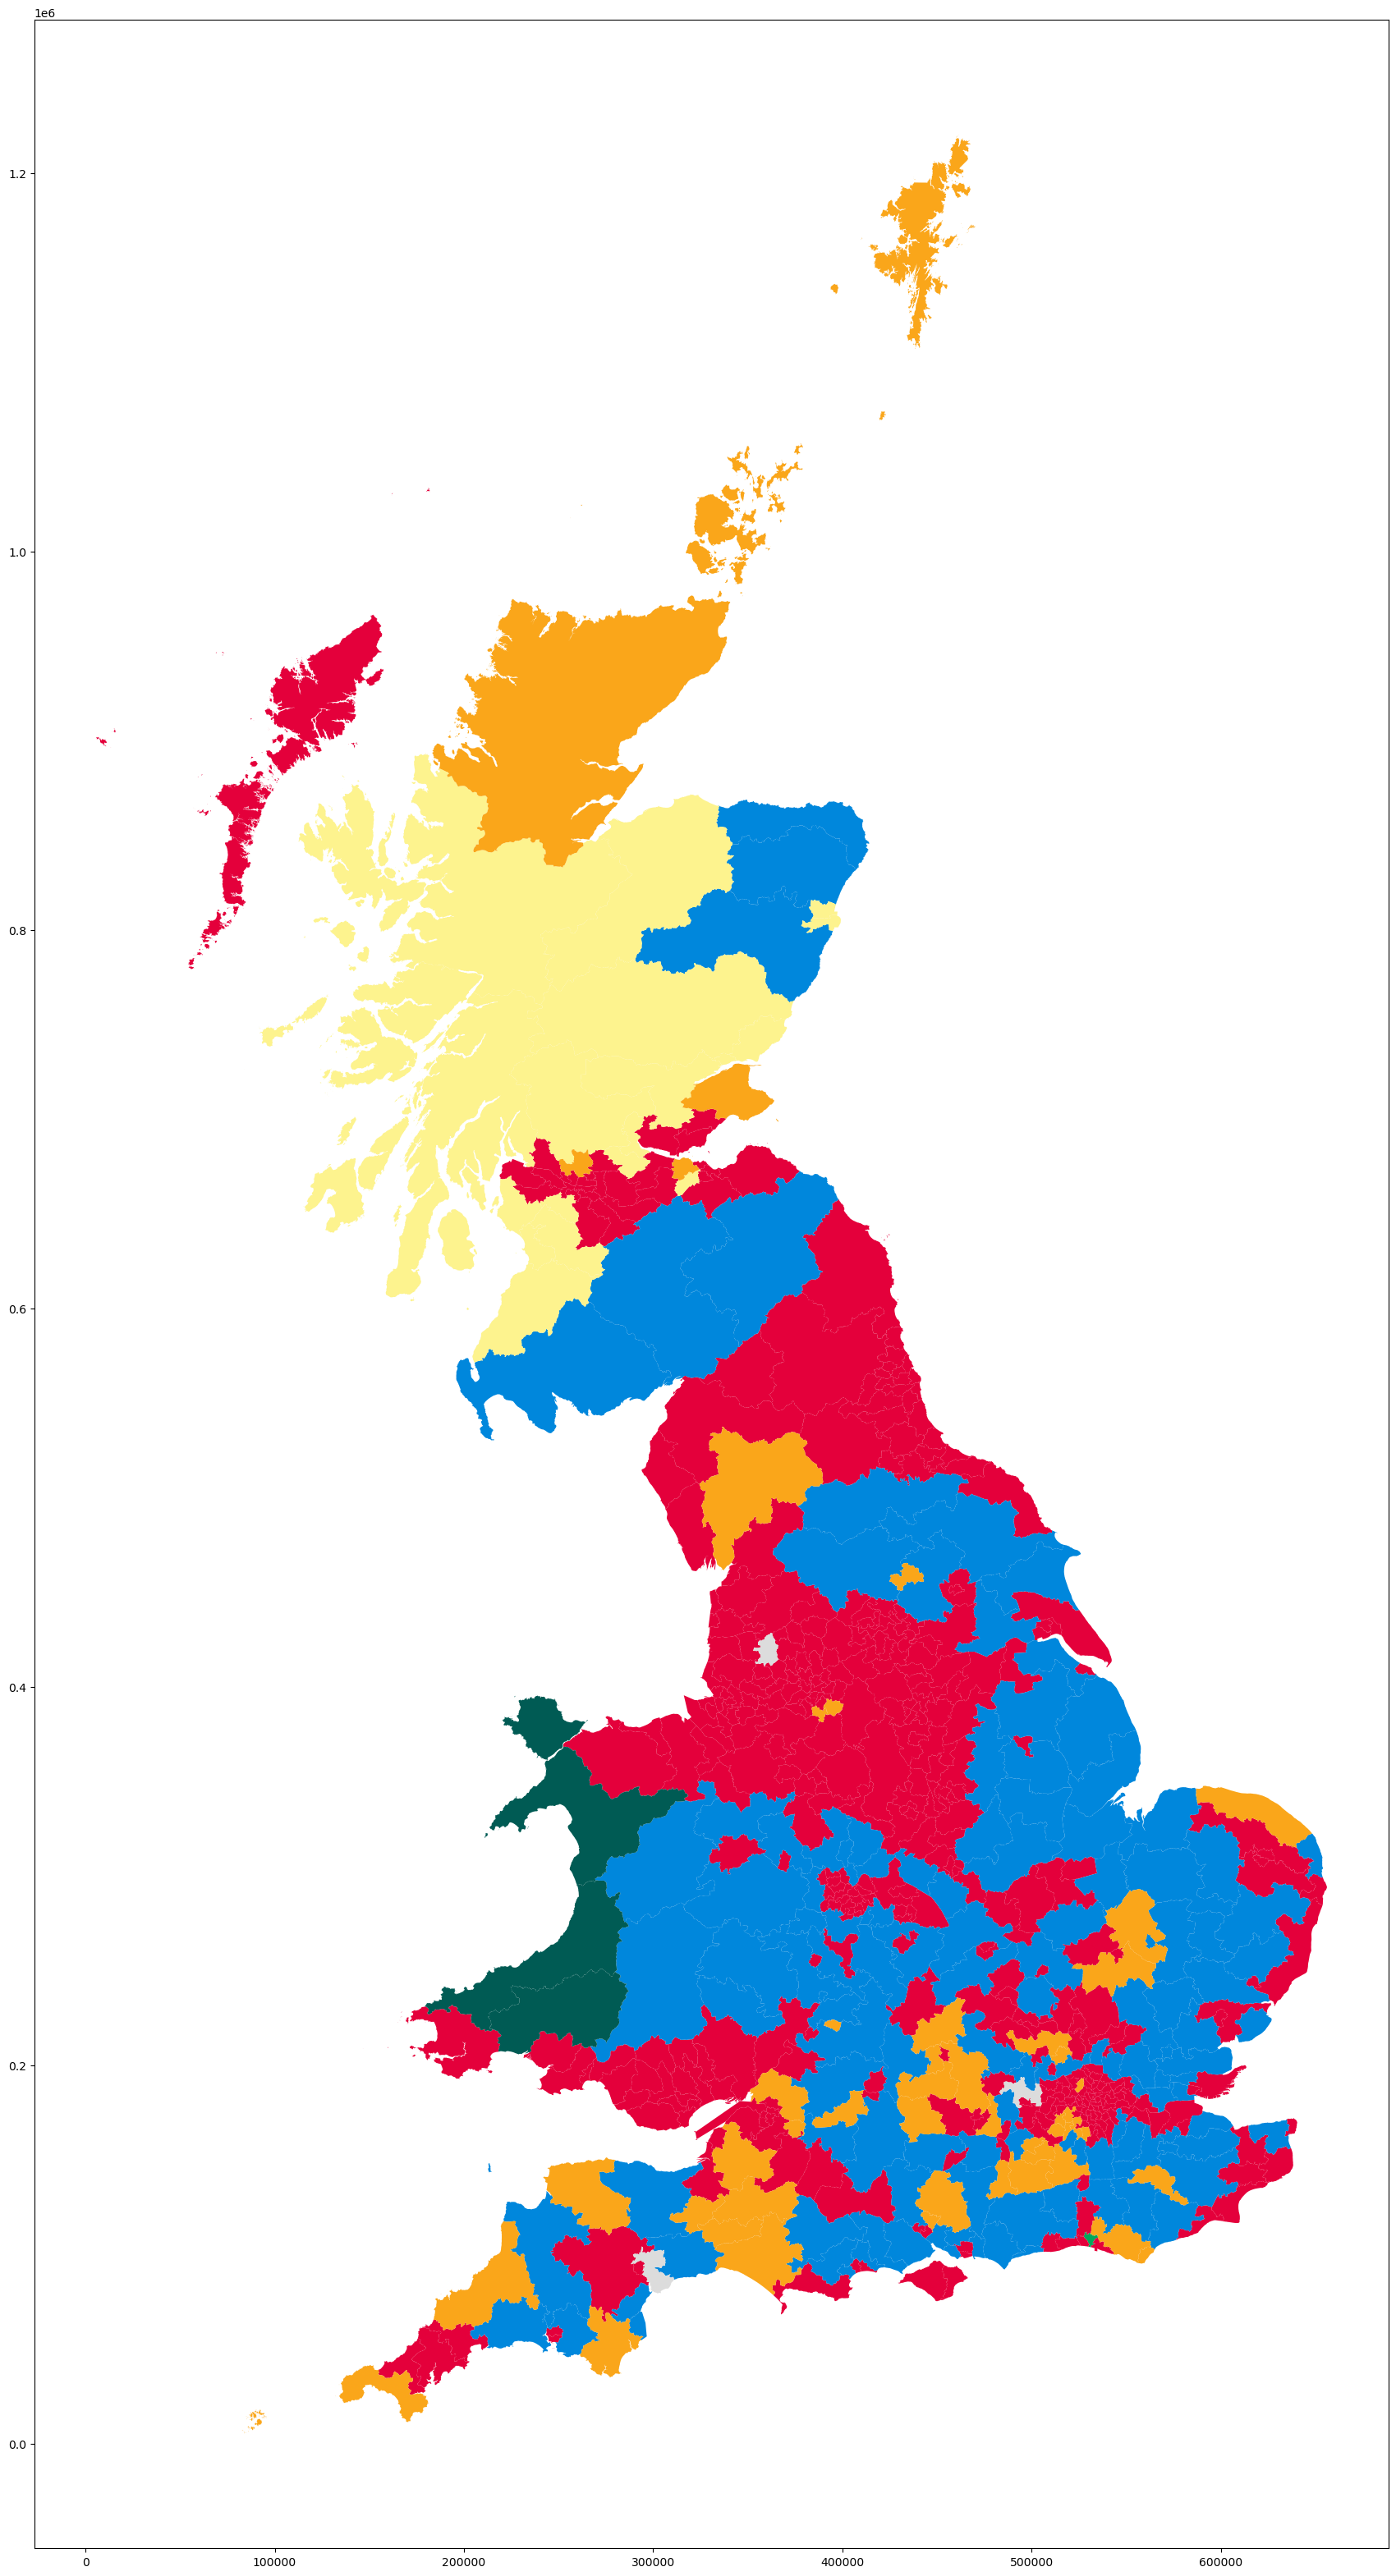

In [11]:
res = predict_2024()

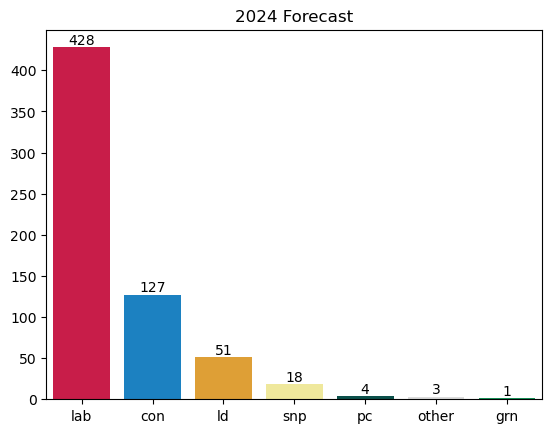

In [12]:
import seaborn as sns

colours = sns.color_palette(list(party_colours.values()))
ordered_colours = {}
for party in res["2024_winner"].value_counts().index:
    ordered_colours[party] = party_colours[party]

ax = sns.barplot(y=res["2024_winner"].value_counts().values, x=list(res["2024_winner"].value_counts().index), hue=res["2024_winner"].value_counts().index, palette=ordered_colours, legend=False)
ax.set_title("2024 Forecast")
for i in ax.containers:
    ax.bar_label(i,)
plt.show()